# Using nbconvert as a library

In this notebook, you will be introduced to the programmatic API of nbconvert and how it can be used in various contexts. 

A great [blog post](http://jakevdp.github.io/blog/2013/04/15/code-golf-in-python-sudoku/) by [@jakevdp](https://github.com/jakevdp) will be used to demonstrate.  This notebook will not focus on using the command line tool. The attentive reader will point-out that no data is read from or written to disk during the conversion process. This is because nbconvert has been designed to work in memory so that it works well in a database or web-based environment too.

## Quick overview

Credit: Jonathan Frederic (@jdfreder on github)

The main principle of nbconvert is to instantiate an `Exporter` that controls the pipeline through which notebooks are converted.

First, download @jakevdp's notebook (if you do not have `requests`, install it by running `pip install requests`, or if you don't have pip installed, you can find it on PYPI):

In [1]:
from urllib.request import urlopen

url = 'http://jakevdp.github.com/downloads/notebooks/XKCD_plots.ipynb'
response = urlopen(url).read().decode()
response[0:60] + ' ...'

'{\n "metadata": {\n  "name": "XKCD_plots"\n },\n "nbformat": 3,\n ...'

The response is a JSON string which represents a Jupyter notebook. 

Next, we will read the response using nbformat. Doing this will guarantee that the notebook structure is valid. Note that the in-memory format and on disk format are slightly different. In particual, on disk, multiline strings might be split into a list of strings.

In [2]:
import nbformat
jake_notebook = nbformat.reads(response, as_version=4)
jake_notebook.cells[0]

{'cell_type': 'markdown',
 'metadata': {},
 'source': '# XKCD plots in Matplotlib'}

The nbformat API returns a special type of dictionary. For this examle, you don't need to worry about the details of the structure (if you are interested, please see the [nbformat documentation](https://nbformat.readthedocs.io/en/latest/)).

The nbconvert API exposes some basic exporters for common formats and defaults. You will start by using one of them. First, you will import one of these exporters (specifically, the HTML exporter), then instantiate it using most of the defaults, and then you will use it to process the notebook we downloaded earlier.

In [3]:
from traitlets.config import Config

# 1. Import the exporter
from nbconvert import HTMLExporter

# 2. Instantiate the exporter. We use the `basic` template for now; we'll get into more details
# later about how to customize the exporter further.
html_exporter = HTMLExporter()
html_exporter.template_file = 'basic'

# 3. Process the notebook we loaded earlier
(body, resources) = html_exporter.from_notebook_node(jake_notebook)

The exporter returns a tuple containing the source of the converted notebook, as well as a resources dict. In this case, the source is just raw HTML:

In [4]:
print(body[:400] + '...')


<div class="cell border-box-sizing text_cell rendered">
<div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h1 id="XKCD-plots-in-Matplotlib">XKCD plots in Matplotlib<a class="anchor-link" href="#XKCD-plots-in-Matplotlib">&#182;</a></h1>
</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered">
<div cl...


If you understand HTML, you'll notice that some common tags are ommited, like the `body` tag.  Those tags are included in the default `HtmlExporter`, which is what would have been constructed if we had not modified the `template_file`.

The resource dict contains (among many things) the extracted `.png`, `.jpg`, etc. from the notebook when applicable.  The basic HTML exporter leaves the figures as embedded base64, but you can configure it to extract the figures.  So for now, the resource dict should be mostly empty, except for a key containing CSS and a few others whose content will be obvious:

In [5]:
print("Resources:", resources.keys())
print("Metadata:", resources['metadata'].keys())
print("Inlining:", resources['inlining'].keys())
print("Extension:", resources['output_extension'])

Resources: dict_keys(['metadata', 'output_extension', 'raw_mimetypes', 'inlining'])
Metadata: dict_keys(['name'])
Inlining: dict_keys(['css'])
Extension: .html


`Exporter`s are stateless, so you won't be able to extract any useful information beyond their configuration.  You can re-use an exporter instance to convert another notebook. In addition to the `from_notebook_node` used above, each exporter exposes `from_file` and `from_filename` methods.

## Extracting Figures using the RST Exporter

When exporting, you may want to extract the base64 encoded figures as files. While the HTML exporter does not do this by default, the `RstExporter` does:

In [6]:
# Import the RST exproter
from nbconvert import RSTExporter
# Instantiate it
rst_exporter = RSTExporter()
# Convert the notebook to RST format
(body, resources) = rst_exporter.from_notebook_node(jake_notebook)

print(body[:970] + '...')
print('[.....]')
print(body[800:1200] + '...')


XKCD plots in Matplotlib

This notebook originally appeared as a blog post at `Pythonic
Perambulations <http://jakevdp.github.com/blog/2012/10/07/xkcd-style-plots-in-matplotlib/>`__
by Jake Vanderplas.

.. raw:: html

   <!-- PELICAN_BEGIN_SUMMARY -->

*Update: the matplotlib pull request has been merged! See* `*This
post* <http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/>`__
*for a description of the XKCD functionality now built-in to
matplotlib!*

One of the problems I've had with typical matplotlib figures is that
everything in them is so precise, so perfect. For an example of what I
mean, take a look at this figure:

.. code:: python

    from IPython.display import Image
    Image('http://jakevdp.github.com/figures/xkcd_version.png')




.. image:: output_3_0.png



Sometimes when showing schematic plots, this is the type of figure I
want to display. But drawing it by hand is a pain: I'd rather just use
matp...
[.....]
image:: output_3_0.png



Sometimes when sh

Notice that base64 images are not embeded, but instead there are filename-like strings, such as `output_3_0.png`.  The strings actually are (configurable) keys that map to the binary data in the resources dict.

Note, if you write an RST Plugin, you are responsible for writing all the files to the disk (or uploading, etc...) in the right location.  Of course, the naming scheme is configurable.

As an exercise, this notebook will show you how to get one of those images. First, take a look at the `'outputs'` of the returned resources dictionary. This is a dictionary that contains a key for each extracted resource, with values corresponding to the actual base64 encoding:

In [7]:
sorted(resources['outputs'].keys())

['output_13_1.png',
 'output_16_0.png',
 'output_18_1.png',
 'output_3_0.png',
 'output_5_0.png']

In this case, there are 5 extracted binary figures, all `png`s. We can use the Image display object to actually display one of the images:

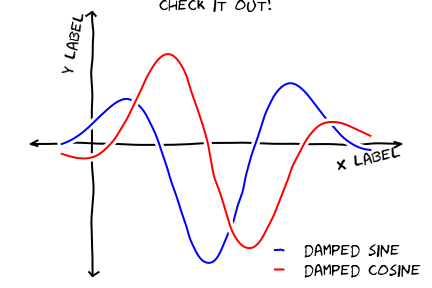

In [8]:
from IPython.display import Image
Image(data=resources['outputs']['output_3_0.png'], format='png')

Note that this image is being rendered without ever reading or writing to the disk.

## Extracting Figures using the HTML Exporter

As mentioned above, by default, the HTML exporter does not extract images -- it just leaves them as inline base64 encodings. However, this is not always what you might want. For example, here is a use case from @jakevdp:

> I write an [awesome blog](http://jakevdp.github.io/) using Jupyter notebooks converted to HTML, and I want the images to be cached.  Having one html file with all of the images base64 encoded inside it is nice when sharing with a coworker, but for a website, not so much.  I need an HTML exporter, and I want it to extract the figures!

### Some theory

Before we get into actually extracting the figures, it will be helpful to give a high-level overview of the process of converting a notebook to a another format:

1. Retrieve the notebook and it's accompanying resources (you are responsible for this).
2. Feed the notebook into the `Exporter`, which:
    1. Sequentially feeds the notebook into an array of `Preprocessor`s.  Preprocessors only act on the **structure** of the notebook, and have unrestricted access to it. 
    2. Feeds the notebook into the Jinja templating engine, which converts it to a particular format depending on which template is selected.
3. The exporter returns the converted notebook and other relevant resources as a tuple.
4. You write the data to the disk using the built-in `FilesWriter` (which writes the notebook and any extracted files to disk), or elsewhere using a custom `Writer`.

### Using different preprocessors

To extract the figures when using the HTML exporter, we will want to change which `Preprocessor`s we are using. There are several preprocessors that come with nbconvert, including one called the `ExtractOutputPreprocessor`.

The `ExtractOutputPreprocessor` is responsible for crawling the notebook, finding all of the figures, and putting them into the resources directory, as well as choosing the key (i.e. `filename_xx_y.extension`) that can replace the figure inside the template. To enable the `ExtractOutputPreprocessor`, we must add it to the exporter's list of preprocessors:

In [9]:
# create a configuration object that changes the preprocessors
from traitlets.config import Config
c = Config()
c.HTMLExporter.preprocessors = ['nbconvert.preprocessors.ExtractOutputPreprocessor']

# create the new exporter using the custom config
html_exporter_with_figs = HTMLExporter(config=c)
html_exporter_with_figs.preprocessors

['nbconvert.preprocessors.ExtractOutputPreprocessor']

We can compare the result of converting the notebook using the original HTML exporter and our new customized one:

In [10]:
(_, resources)          = html_exporter.from_notebook_node(jake_notebook)
(_, resources_with_fig) = html_exporter_with_figs.from_notebook_node(jake_notebook)

print("resources without figures:")
print(sorted(resources.keys()))

print("\nresources with extracted figures (notice that there's one more field called 'outputs'):")
print(sorted(resources_with_fig.keys()))

print("\nthe actual figures are:")
print(sorted(resources_with_fig['outputs'].keys()))

resources without figures:
['inlining', 'metadata', 'output_extension', 'raw_mimetypes']

resources with extracted figures (notice that there's one more field called 'outputs'):
['inlining', 'metadata', 'output_extension', 'outputs', 'raw_mimetypes']

the actual figures are:
['output_13_1.png', 'output_16_0.png', 'output_18_1.png', 'output_3_0.png', 'output_5_0.png']


## Custom Preprocessors

There are an endless number of transformations that you may want to apply to a notebook.  In particularly complicated cases, you may want to actually create your own `Preprocessor`. Above, when we customized the list of preprocessors accepted by the `HTMLExporter`, we passed in a string -- this can be any valid module name. So, if you create your own preprocessor, you can include it in that same list and it will be used by the exporter.

To create your own preprocessor, you will need to subclass from `nbconvert.preprocessors.Preprocessor` and overwrite either the `preprocess` and/or `preprocess_cell` methods.

## Example

The following demonstration adds the ability to exclude a cell by index. 

Note: injecting cells is similar, and won't be covered here. If you want to inject static content at the beginning/end of a notebook, use a custom template.

In [1]:
from traitlets import Integer
from nbconvert.preprocessors import Preprocessor

class PelicanSubCell(Preprocessor):
    """A Pelican specific preprocessor to remove some of the cells of a notebook"""
    
    # I could also read the cells from nb.metadata.pelican if someone wrote a JS extension,
    # but for now I'll stay with configurable value. 
    start = Integer(0,  help="first cell of notebook to be converted")
    end   = Integer(-1, help="last cell of notebook to be converted")
    start.tag(config='True')
    end.tag(config='True')
    
    def preprocess(self, nb, resources):
        self.log.info("I'll keep only cells from %d to %d", self.start, self.end)
        nb.cells = nb.cells[self.start:self.end]                    
        return nb, resources

Here a Pelican exporter is created that takes `PelicanSubCell` preprocessors and a `config` object as parameters.  This may seem redundant, but with the configuration system you can register an inactive preprocessor on all of the exporters and activate it from config files or the command line. 

In [12]:
# Create a new config object that configures both the new preprocessor, as well as the exporter
c =  Config()
c.PelicanSubCell.start = 4
c.PelicanSubCell.end = 6
c.RSTExporter.preprocessors = [PelicanSubCell]

# Create our new, customized exporter that uses our custom preprocessor
pelican = RSTExporter(config=c)

# Process the notebook
print(pelican.from_notebook_node(jake_notebook)[0])


Sometimes when showing schematic plots, this is the type of figure I
want to display. But drawing it by hand is a pain: I'd rather just use
matplotlib. The problem is, matplotlib is a bit too precise. Attempting
to duplicate this figure in matplotlib leads to something like this:

.. code:: python

    Image('http://jakevdp.github.com/figures/mpl_version.png')




.. image:: output_5_0.png





## Programatically creating templates

In [13]:
from jinja2 import DictLoader

dl = DictLoader({'full.tpl': 
"""
{%- extends 'basic.tpl' -%} 

{% block footer %}
FOOOOOOOOTEEEEER
{% endblock footer %}
"""})


exportHTML = HTMLExporter(extra_loaders=[dl])
(body, resources) = exportHTML.from_notebook_node(jake_notebook)
for l in body.split('\n')[-4:]:
    print(l)

</div>
</div>
FOOOOOOOOTEEEEER



## Real World Uses

@jakevdp uses Pelican and Jupyter Notebook to blog. Pelican [will use](https://github.com/getpelican/pelican-plugins/pull/21) nbconvert programatically to generate blog post. Have a look a [Pythonic Preambulations](http://jakevdp.github.io/) for Jake's blog post.

@damianavila wrote the Nikola Plugin to [write blog post as Notebooks](http://www.damian.oquanta.info/posts/one-line-deployment-of-your-site-to-gh-pages.html) and is developping a js-extension to publish notebooks via one click from the web app.

<center>
<blockquote class="twitter-tweet"><p>As <a href="https://twitter.com/Mbussonn">@Mbussonn</a> requested... easieeeeer! Deploy your Nikola site with just a click in the IPython notebook! <a href="http://t.co/860sJunZvj">http://t.co/860sJunZvj</a> cc <a href="https://twitter.com/ralsina">@ralsina</a></p>&mdash; Damián Avila (@damian_avila) <a href="https://twitter.com/damian_avila/statuses/370306057828335616">August 21, 2013</a></blockquote>
</center>